# Stress Detector on AWS

A stress detector model deployed on AWS Lambda that detects stress in specific stress-related Reddit subreddits. I did this project to gain hands-on experience with cloud deployments. This is an old project that I never pushed, so it's been updated to the latest Python version and libraries, and well, here we are.

I wanted the model to be light and suitable enough to be able to run as a Lambda service, so I kept things very simple; I utilized scikit-learn's TF-IDF vectorizer for text preprocessing and trained a logistic regression classifier, achieving an accuracy of 72%. For deployment, I containerized the model with Docker. The image builds are hosted on AWS ECR and automatically deployed to AWS Lambda. At the end, I implemented CI/CD pipelines via GitHub Actions for seamless integration and deployment, along with monitoring capabilities. The model is exposed through an API, allowing for easy access and interaction with the stress detection functionality.

The idea for the project was inspired by the paper "Dreaddit: A Reddit Dataset for Stress Analysis in Social Media" (https://arxiv.org/abs/1911.00133) by Elsbeth Turcan and Kathleen McKeown. You can learn more about the research by reading the paper. The dataset can be found on Papers with Code (https://paperswithcode.com/dataset/dreaddit).

In [1]:
import warnings 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')
plt.rcParams['font.family'] = 'Arial'
sns.set_style('whitegrid')

%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('dreaddit-train.csv')
test_df = pd.read_csv('dreaddit-test.csv')

In [3]:
train_df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,lex_liwc_posemo,lex_liwc_negemo,lex_liwc_anx,lex_liwc_anger,lex_liwc_sad,lex_liwc_social,lex_liwc_family,lex_liwc_friend,lex_liwc_female,lex_liwc_male,lex_liwc_cogproc,lex_liwc_insight,lex_liwc_cause,lex_liwc_discrep,lex_liwc_tentat,lex_liwc_certain,lex_liwc_differ,lex_liwc_percept,lex_liwc_see,lex_liwc_hear,lex_liwc_feel,lex_liwc_bio,lex_liwc_body,lex_liwc_health,lex_liwc_sexual,lex_liwc_ingest,lex_liwc_drives,lex_liwc_affiliation,lex_liwc_achieve,lex_liwc_power,lex_liwc_reward,lex_liwc_risk,lex_liwc_focuspast,lex_liwc_focuspresent,lex_liwc_focusfuture,lex_liwc_relativ,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,lex_dal_max_pleasantness,lex_dal_max_activation,lex_dal_max_imagery,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,116,72.64,15.04,89.26,1.00,29.00,12.93,87.07,56.03,16.38,12.07,9.48,0.00,0.86,1.72,0.0,4.31,3.45,19.83,7.76,5.17,4.31,1.72,16.38,6.03,3.45,0.86,1.72,1.72,8.62,1.72,6.90,0.86,2.59,3.45,3.45,0.00,0.00,0.00,1.72,11.21,3.45,0.86,2.59,5.17,0.00,2.59,6.03,1.72,1.72,1.72,2.59,0.86,1.72,0.00,0.00,8.62,0.00,1.72,4.31,0.86,2.59,4.31,11.21,0.86,17.24,0.86,10.34,6.03,0.86,0.00,0.00,0.00,2.59,0.0,0.86,0.86,0.00,0.00,0.0,0.0,21.55,9.48,3.45,0.86,0.86,0.0,0.0,0.0,5.17,1.72,0.00,0.00,2.8571,2.6250,3.0,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,109,79.08,76.85,56.75,98.18,27.25,21.10,87.16,48.62,11.93,7.34,1.83,2.75,2.75,0.00,0.0,4.59,8.26,13.76,6.42,3.67,8.26,0.92,15.60,2.75,0.92,0.92,2.75,0.92,5.50,5.50,0.00,0.00,0.00,0.00,11.01,0.00,0.00,0.00,0.00,11.93,1.83,0.00,3.67,5.50,1.83,6.42,0.92,0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.60,5.50,3.67,7.34,2.75,0.00,0.92,13.76,0.92,15.60,2.75,10.09,1.83,11.01,0.00,0.00,0.92,0.00,0.0,1.83,0.00,0.92,0.00,0.0,0.0,14.68,4.59,2.75,0.00,0.00,0.0,0.0,0.0,0.00,2.75,0.92,3.67,3.0000,2.8889,3.0,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,167,33.80,76.38,86.24,25.77,33.40,17.37,91.02,61.68,25.15,16.17,8.98,1.80,1.80,2.99,0.6,8.98,5.39,12.57,10.18,1.80,5.99,1.20,20.96,1.20,0.60,0.60,1.20,1.80,2.40,1.20,1.20,0.00,0.00,0.00,15.57,0.60,3.59,1.80,2.40,10.18,4.19,1.20,0.60,2.99,0.00,1.80,0.00,0.00,0.00,0.00,0.60,0.60,0.00,0.00,0.00,8.98,5.39,0.60,1.20,2.40,0.00,3.59,14.37,1.80,16.17,4.79,5.99,5.39,0.00,1.20,0.60,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,10.78,2.40,3.59,0.00,0.00,0.6,0.0,0.0,2.40,1.80,0.00,0.00,2.7143,3.0000,3.0,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,273,2.98,15.25,95.42,79.26,54.60,8.06,98.90,65.57,

In [4]:
test_df.head()

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,lex_liwc_posemo,lex_liwc_negemo,lex_liwc_anx,lex_liwc_anger,lex_liwc_sad,lex_liwc_social,lex_liwc_family,lex_liwc_friend,lex_liwc_female,lex_liwc_male,lex_liwc_cogproc,lex_liwc_insight,lex_liwc_cause,lex_liwc_discrep,lex_liwc_tentat,lex_liwc_certain,lex_liwc_differ,lex_liwc_percept,lex_liwc_see,lex_liwc_hear,lex_liwc_feel,lex_liwc_bio,lex_liwc_body,lex_liwc_health,lex_liwc_sexual,lex_liwc_ingest,lex_liwc_drives,lex_liwc_affiliation,lex_liwc_achieve,lex_liwc_power,lex_liwc_reward,lex_liwc_risk,lex_liwc_focuspast,lex_liwc_focuspresent,lex_liwc_focusfuture,lex_liwc_relativ,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,lex_dal_max_pleasantness,lex_dal_max_activation,lex_dal_max_imagery,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,896,relationships,7nu7as,"[50, 55]","Its like that, if you want or not.“ ME: I have...",0,0.8,1.514981e+09,22,-1.238793,55,2.82,57.22,55.41,5.95,11.00,7.27,94.55,67.27,29.09,18.18,5.45,0.00,9.09,3.64,0.00,10.91,0.00,12.73,7.27,1.82,14.55,7.27,18.18,1.82,3.64,1.82,5.45,0.00,1.82,0.00,1.82,0.00,0.0,0.00,20.00,0.0,1.82,0.0,3.64,20.00,0.00,0.00,7.27,7.27,0.00,14.55,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,7.27,3.64,0.00,1.82,1.82,1.82,5.45,10.91,3.64,12.73,0.00,1.82,10.91,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,23.64,12.73,5.45,1.82,0.00,0.00,0.0,0.0,1.82,1.82,0.00,0.00,2.7143,2.8889,2.6,1.0000,1.2000,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000
1,19059,anxiety,680i6d,"(5, 10)",I man the front desk and my title is HR Custom...,0,1.0,1.493348e+09,5,7.684583,72,64.56,50.00,31.19,92.40,14.40,25.00,84.72,44.44,9.72,8.33,6.94,1.39,0.00,0.00,0.00,1.39,5.56,11.11,8.33,5.56,8.33,0.00,13.89,1.39,0.00,2.78,2.78,1.39,4.17,4.17,0.00,0.00,0.0,0.00,6.94,0.0,0.00,0.0,1.39,9.72,4.17,1.39,1.39,2.78,0.00,1.39,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,11.11,2.78,2.78,2.78,4.17,0.00,1.39,13.89,1.39,6.94,1.39,4.17,1.39,22.22,0.00,0.0,4.17,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,15.28,6.94,4.17,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,4.17,2.4444,2.8889,3.0,1.4000,1.1250,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909
2,7977,ptsd,8eeu1t,"(5, 10)",We'd be saving so much money with this new hou...,1,1.0,1.524517e+09,10,2.360408,148,14.79,75.05,62.88,16.15,21.14,10.81,94.59,59.46,23.65,14.19,6.08,2.03,0.68,2.70,2.70,9.46,2.70,12.16,10.14,6.08,9.46,0.68,20.27,4.73,2.70,0.68,1.35,2.03,3.38,1.35,2.03,0.68,0.0,1.35,14.86,0.0,0.68,0.0,2.70,9.46,2.03,0.00,3.38,3.38,0.68,4.05,0.68,0.68,0.00,0.00,2.70,0.0,2.70,0.0,0.0,5.41,2.70,0.00,1.35,1.35,0.00,6.08,12.16,1.35,16.89,2.03,8.11,6.76,0.68,0.00,0.0,2.03,0.0,0.68,2.70,0.0,0.00,0.68,0.68,0.0,17.57,16.22,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1.35,0.00,0.00,2.8333,2.9091,3.0,1.1429,1.0000,1.0,1.70974,1.52985,1.86108,1.00,8,3.149288,-0.036818
3,1214,ptsd,8d28vu,"[2, 7]","My ex used to shoot back with ""Do you want me ...",1,0.5,1.524018e+09,5,5.997000,100,32.13,38.19,79.76,12.51,20.00,9.00,92.00,64.00,28.00,1

In [5]:
# Check for NaNs
nan_value = train_df.isnull().values.any()
nan_result = train_df.isnull().sum()

print("Any missing values (NaNs):", nan_value)
print("\nCount of missing values (NaNs) for each column:")
print(nan_result)

Any missing values (NaNs): False

Count of missing values (NaNs) for each column:
subreddit                   0
post_id                     0
sentence_range              0
text                        0
id                          0
                           ..
lex_dal_avg_pleasantness    0
social_upvote_ratio         0
social_num_comments         0
syntax_fk_grade             0
sentiment                   0
Length: 116, dtype: int64


In [6]:
# Check for duplicates
duplicate_value = train_df.duplicated().any()
duplicate_result = train_df.duplicated().sum()

print("Any duplicate values:", duplicate_value)
print("\nCount of duplicate rows:", duplicate_result)

Any duplicate values: False

Count of duplicate rows: 0


In [7]:
# Check for data imbalance in the target
train_df['label'].value_counts()

label
1    1488
0    1350
Name: count, dtype: int64

In [8]:
X_train = train_df['text']
y_train = train_df['label']

X_test = test_df['text']
y_test = test_df['label']

In [9]:
X_train.head()

0    He said he had not felt that way before, sugge...
1    Hey there r/assistance, Not sure if this is th...
2    My mom then hit me with the newspaper and it s...
3    until i met my new boyfriend, he is amazing, h...
4    October is Domestic Violence Awareness Month a...
Name: text, dtype: object

In [10]:
X_test.head()

0    Its like that, if you want or not.“ ME: I have...
1    I man the front desk and my title is HR Custom...
2    We'd be saving so much money with this new hou...
3    My ex used to shoot back with "Do you want me ...
4    I haven’t said anything to him yet because I’m...
Name: text, dtype: object

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on train data
X_train = vectorizer.fit_transform(X_train)

# Transform vectorizer on test data
X_test = vectorizer.transform(X_test)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from alive_progress import alive_it

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(verbose=0)
}

# Define evaluation metrics
metrics = {
    'Accuracy': accuracy_score,
    'Precision (Class 0)': lambda y_true, y_pred: precision_score(y_true, y_pred, pos_label=0),
    'Precision (Class 1)': lambda y_true, y_pred: precision_score(y_true, y_pred, pos_label=1),
    'Recall (Class 0)': lambda y_true, y_pred: recall_score(y_true, y_pred, pos_label=0),
    'Recall (Class 1)': lambda y_true, y_pred: recall_score(y_true, y_pred, pos_label=1),
    'F1-score (Class 0)': lambda y_true, y_pred: f1_score(y_true, y_pred, pos_label=0),
    'F1-score (Class 1)': lambda y_true, y_pred: f1_score(y_true, y_pred, pos_label=1),
    'ROC AUC': roc_auc_score,
}

# Initialize results dictionary
results = {metric: {name: None for name in classifiers} for metric in metrics}

# Evaluate classifiers and store results for each metric
for name, classifier in alive_it(classifiers.items(), force_tty=True, stats="eta: {eta}"):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    for metric_name, metric_func in metrics.items():
        results[metric_name][name] = metric_func(y_test, y_pred)

# Convert dictionary to DataFrame
metrics_df = pd.DataFrame(results)

# Sort by accuracy
metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)

# Formatting accuracy column
metrics_df['Accuracy'] = (metrics_df['Accuracy'] * 100).round(2).astype(str) + '%'

# Set index
metrics_df.index.name = 'Algorithm'

metrics_df

|████████████████████████████████████████| 8/8 [100%] in 23.9s (0.30/s)          [25%] in 2s eta: ~5s 


,Accuracy,Precision (Class 0),Precision (Class 1),Recall (Class 0),Recall (Class 1),F1-score (Class 0),F1-score (Class 1),ROC AUC
Algorithm,,,,,,,,
LightGBM,72.59%,0.743506,0.712531,0.661850,0.785908,0.700306,0.747423,0.723879
Logistic Regression,72.31%,0.741830,0.709046,0.656069,0.785908,0.696319,0.745501,0.720989
SVM,72.17%,0.730408,0.714646,0.673410,0.766938,0.700752,0.739869,0.720174
Random Forest,71.33%,0.776471,0.678261,0.572254,0.845528,0.658902,0.752714,0.708891
XGBoost,71.33%,0.722397,0.706030,0.661850,0.761518,0.690799,0.732725,0.711684
Gradient Boosting,70.77%,0.726073,0.694175,0.635838,0.775068,0.677966,0.732394,0.705453
K-Nearest Neighbors,66.15%,0.714876,0.634249,0.500000,0.813008,0.588435,0.712589,0.656504
Decision Tree,58.74%,0.580952,0.592500,0.528902,0.642276,0.553707,0.616385,0.585589


In [13]:
from sklearn.metrics import classification_report

# Fit logistic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       346
           1       0.71      0.79      0.75       369

    accuracy                           0.72       715
   macro avg       0.73      0.72      0.72       715
weighted avg       0.72      0.72      0.72       715



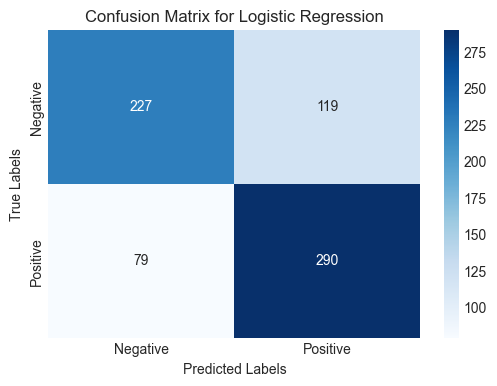

In [14]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

class_labels = ["Negative", "Positive"]

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [15]:
import joblib

# Save the trained LR model
joblib.dump(lr, 'lr_stress_tfidf.joblib')

# Saved the trained vectorizer
joblib.dump(vectorizer, 'train_vectorizer.joblib')

print("ML model and vectorizer imported.")

ML model and vectorizer imported.


In [16]:
import joblib

# Load the model and vectorizer for testing
lr = joblib.load('lr_stress_tfidf.joblib')
vectorizer = joblib.load('train_vectorizer.joblib')

# Test a sentence on the data
new_sentence = "I'm really worried about my health. What should I do? I think I'm gonna lose my mind..."

new_sentence_tfidf = vectorizer.transform([new_sentence])

new_prediction = lr.predict(new_sentence_tfidf)

predicted_label = 'stress' if new_prediction[0] == 1 else 'not stress'

print(f"Predicted Label: {predicted_label}")

Predicted Label: stress
